In [1]:
import numpy as np
import pandas as pd
import openturns as ot
from matplotlib import pyplot as plt
from bancs import *

In [32]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [6]:
g = ot.SymbolicFunction(['x1', 'x2', 'x3'], ['sin(x1) + 7.0 * sin(x2)^2 + 0.1 * x3^4 * sin(x1)'])
X = ot.ComposedDistribution([ot.Uniform(-np.pi, np.pi)] * 3)
X.setDescription(["$x_1$", "$x_2$", "$x_3$"])
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), -10.)
pf_ref = 0.00019120999999997415

In [14]:
N = int(1e4)
m = int(1 + np.floor(N ** (2 / (4 + 3))))
m

14

In [15]:
bancs = BANCS(failure_event, N=N, M=m, p0=0.1)
quantiles = bancs.run()
pf = bancs.compute_pf()
print("Quantiles =", quantiles)
print("Proba EBC = {:.2e}".format(pf))
print("Relative error = {:.2%}".format(np.abs(pf - pf_ref) / pf_ref))
df = bancs.df.copy()
nb_subset = len(df['Subset'].unique())

Quantiles = [ -0.78116372  -7.14725776 -10.70868256]
Proba EBC = 1.93e-04
Relative error = 1.05%


In [16]:
multindex = pd.MultiIndex.from_product([["Subset {}".format(l + 1) for l in range(nb_subset)], list(X.getDescription())], names=["sample", "variable"])
df_tsa = pd.DataFrame([], columns=multindex, index=["HSIC", "R2HSIC", "pvalue_asymptotic", "pvalue_permutation"])
df_csa = pd.DataFrame([], columns=multindex, index=["HSIC", "R2HSIC", "pvalue_permutation"])

In [17]:
f = ot.SymbolicFunction(["x", "s"], ["exp(-x/s)"])
estimatorType = ot.HSICUStat()
for l in range(nb_subset):
    ssample = df[(df["Subset"]==l)][list(X.getDescription())].values
    ssample_output = df[(df["Subset"]==l)]["Y"].values.reshape(-1, 1)
    ssample_stds = ssample.std(axis=0)
    ssample_stds = np.append(ssample_stds, ssample_output.std())
    #ssample_stds.append(ssample_output.computeStandardDeviation()[0])
    kernel_collection = [ot.SquaredExponential([std_i]) for std_i in ssample_stds]
    dist2criticalDomain = ot.DistanceToDomainFunction(ot.Interval(quantiles[l], float("inf")))
    s = 0.1 * ssample_output.std()
    phi = ot.ParametricFunction(f, [1], [s])
    filterFunction = ot.ComposedFunction(phi, dist2criticalDomain)
    # TSA with HSIC indices
    tsa = ot.HSICEstimatorTargetSensitivity(kernel_collection, ot.Sample(ssample), ot.Sample(ssample_output), 
                                            ot.HSICUStat(), filterFunction)
    df_tsa.loc["HSIC", "Subset {}".format(l + 1)] = list(tsa.getHSICIndices())
    df_tsa.loc["R2HSIC", "Subset {}".format(l + 1)] = list(tsa.getR2HSICIndices())
    df_tsa.loc["pvalue_asymptotic", "Subset {}".format(l + 1)] = list(tsa.getPValuesAsymptotic())
    #df_tsa.loc["pvalue_permutation", "Subset {}".format(l + 1)] = list(tsa.getPValuesPermutation())
    #CSA with HSIC indices
    csa = ot.HSICEstimatorConditionalSensitivity(kernel_collection, ot.Sample(ssample), ot.Sample(ssample_output), filterFunction)
    df_csa.loc["HSIC", "Subset {}".format(l + 1)] = list(csa.getHSICIndices())
    df_csa.loc["R2HSIC", "Subset {}".format(l + 1)] = list(csa.getR2HSICIndices())
    #df_csa.loc["pvalue_permutation", "Subset {}".format(l + 1)] = list(csa.getPValuesPermutation())

In [25]:
df_tsa_plot = df_tsa.T.reorder_levels(["variable", "sample"])
df_csa_plot = df_csa.T.reorder_levels(["variable", "sample"])
df_tsa_plot.to_csv("rosa_results/ishigami_tsa.csv")
df_csa_plot.to_csv("rosa_results/ishigami_csa.csv")
df_tsa_plot = df_tsa_plot.reset_index()
df_csa_plot = df_csa_plot.reset_index()
df_csa_plot

,variable,sample,HSIC,R2HSIC,pvalue_permutation
0,$x_1$,Subset 1,0.009653,0.119962,NaN
1,$x_2$,Subset 1,0.000577,0.007081,NaN
2,$x_3$,Subset 1,0.00157,0.020302,NaN
3,$x_1$,Subset 2,0.00142,0.01966,NaN
4,$x_2$,Subset 2,0.000227,0.003035,NaN
5,$x_3$,Subset 2,0.003558,0.038592,NaN
6,$x_1$,Subset 3,0.001801,0.025618,NaN
7,$x_2$,Subset 3,0.000161,0.002228,NaN
8,$x_3$,Subset 3,0.000158,0.001557,NaN


In [38]:
def draw_indices(df, column, ylabel, savefile=None): 
    nb_subset = len(df["sample"].unique())
    xplot = np.arange(nb_subset)
    fig = plt.figure(figsize=(5, 4))
    for i, var in enumerate(df["variable"].unique()):
        sub_df = df[df["variable"]==var]
        plt.plot(xplot, sub_df[column].values, color="C{}".format(i), marker="o", label=var)
    plt.yscale("log")
    plt.grid()
    plt.xlabel("BANCS samples ($N=10^4$)")
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.3, 1.), loc='upper right', ncol=1)
    plt.xticks(xplot, [f"S{i+1}" for i in xplot])
    if savefile is not None: 
        plt.savefig(savefile, dpi=300, bbox_inches='tight')
    return fig

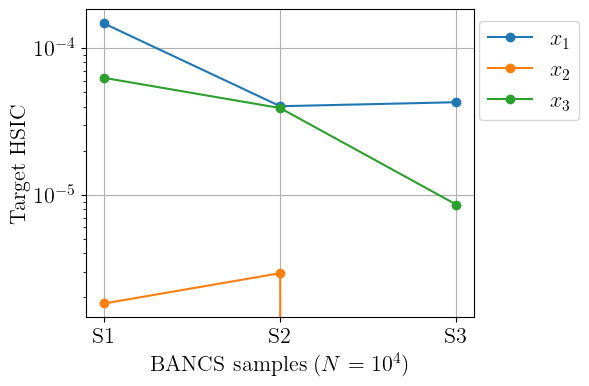

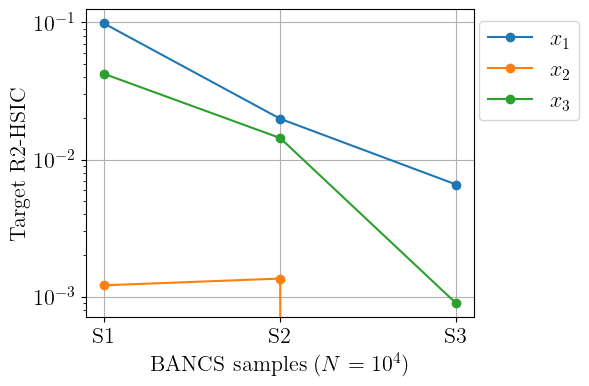

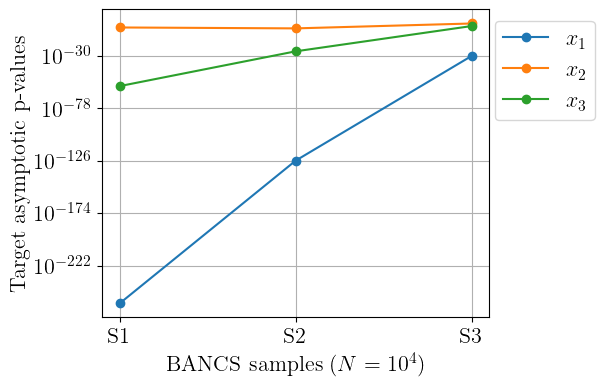

In [39]:
## TSA figures ##
# HSIC
draw_indices(df_tsa_plot, "HSIC", "Target HSIC", "rosa_figures/ishigami_THSIC.png")
# R2HSIC
draw_indices(df_tsa_plot, "R2HSIC", "Target R2-HSIC", "rosa_figures/ishigami_TR2HSIC.png")
# P-values asymptotic
draw_indices(df_tsa_plot, "pvalue_asymptotic", "Target asymptotic p-values", "rosa_figures/ishigami_Tpvalue_asymptotic.png");
# P-values permutation
#draw_indices(df_tsa_plot, "pvalue_permutation", "Target permutation p-values", "rosa_figures/ishigami_Tpvalue_permutation.png");

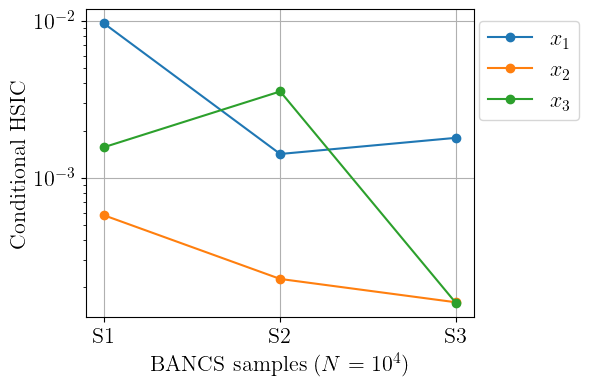

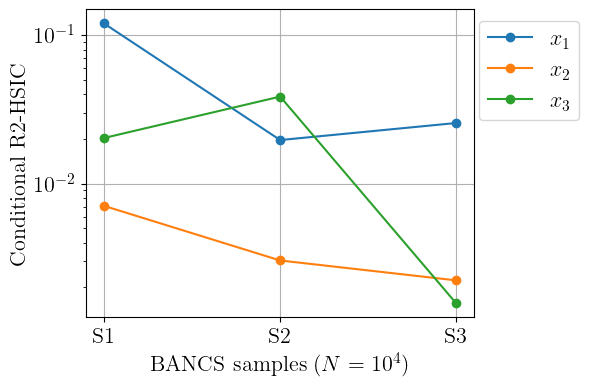

In [40]:
## CSA figures ##
# HSIC
draw_indices(df_csa_plot, "HSIC", "Conditional HSIC", "rosa_figures/ishigami_CHSIC.png")
# R2HSIC
draw_indices(df_csa_plot, "R2HSIC", "Conditional R2-HSIC", "rosa_figures/ishigami_CR2HSIC.png");
# P-values permutation
#draw_indices(df_csa_plot, "pvalue_permutation", "Conditional permutation p-values", "rosa_figures/ishigami_Cpvalue_permutation.png");